# Analyzing data
In this part we will read the dataset, manipulate and visualize overviewed information. The dataset contains 12 fields, including 10 information columns, 1 column for passenger ID which is meaningless, and 1 column for labels. We will use `pandas` library to load and analyze the correlation between each field and the labels (survival status of passengers).  
Noted that some `str` fields will be converted from categorical data to numerical data (such as "Sex" and "Embarked"), meanwhile others will be obmitted (such as "Name", "Ticket" and "Cabin") because they are pure string and can not be calculated correlations. In first view, perhaps they need to be preprocessed to obtain more meaningful information. For example, some rules can be hidden inside name of the passengers, let us say "if the name contains 'Master', that should be a passenger of the business class rather than others in the economic class". However this information may not affects too much to the survival status, because other fields have already covered those rules, let us say the price of the ticket can represent the class of the passengers. 

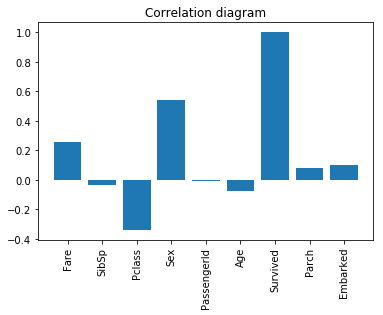

In [122]:
import pandas
import matplotlib.pyplot as plt

survival_field = "Survived"
data = pandas.read_csv("./data/train.csv")
correlations = {}
for field in data.keys():
    if field in ["Name", "Ticket", "Cabin"]:
        del data[field]
        continue
    elif field in ["Sex","Embarked"]:
        data[field] = pandas.factorize(data[field])[0]
    correlations[field] = data[survival_field].corr(data[field], method="pearson")

plt.bar(range(len(correlations)), correlations.values(), align='center')
plt.xticks(range(len(correlations)), correlations.keys(), rotation='vertical')
plt.title('Correlation diagram')
plt.show()

# First trial
We will directly use the considered fields to create feature vectors and apply some traditional methods to solve this problem, in order to have a clear overview as well as understanding the hard key points of this.  
Firstly, we split the dataset into training and testing sets (70% for training), then try using Support Vector Machine (SVM) with kernel "linear".

In [124]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

data = data.sample(frac=1).reset_index(drop=True)
data = data.fillna(0)
trainingData = data[:int(0.7*len(data))]
testingData = data[int(0.7*len(data)):]
trainingData = trainingData.values
testingData = testingData.values

X = trainingData[:, 2:]
Y = trainingData[:, 1]
clf = SVC(kernel="linear")
clf.fit(X, Y)

x = testingData[:, 2:]
y = testingData[:, 1]
z = clf.predict(x)

accuracy = accuracy_score(y, z)
print("Accuracy using SVM-linear: ", accuracy)

Accuracy using SVM-linear:  0.7686567164179104


Save the model if needed:

In [116]:
from sklearn.externals import joblib

joblib.dump(clf, './data/svm.pkl') 

['./data/svm.pkl']

And perform prediction in the blind test to get the final result if needed:

In [170]:
numericData = data.values
Xall = numericData[:, 2:]
Yall = numericData[:, 1]
clf = SVC(kernel="linear")
clf.fit(Xall, Yall)

blindData = pandas.read_csv("./data/test.csv")
for field in blindData.keys():
    if field in ["Name", "Ticket", "Cabin"]:
        del blindData[field]
        continue
    elif field in ["Sex","Embarked"]:
        blindData[field] = pandas.factorize(blindData[field])[0]

blindData = blindData.fillna(0)
numericBlindData = blindData.values
predictedResult = clf.predict(numericBlindData[:, 1:])
with open("./data/predicted.csv", "w") as file:
    file.write("PassengerId,Survived\n")
    for i in range(len(predictedResult)):
        file.write(str(int(numericBlindData[i, 0]))+","+str(int(predictedResult[i]))+"\n")

__The final accuracy after submitting to Kaggle by this method is 0.76555.__
# Implementation
Now we try to convert categorical fields into one-hot features and hopefully it can improve the performance. To do that we implement a module to preprocess from the input data file.  
Changing kernel of SVM to "rbf" and only using features of fields "Pclass", "Sex", "Embarked", "Fare" and "Age" we can get a slightly improvement, __accuracy 0.77990 from Kaggle__.

In [234]:
import random
import numpy
from src.process import Preprocessor

data2 = Preprocessor.process_data("./data/train.csv")
data2 = Preprocessor.convert_data(data2)
random.shuffle(data2)
trainingData2 = data2[:int(0.7*len(data2))]
testingData2 = data2[int(0.7*len(data2)):]
trainingData2 = numpy.array(trainingData2)
testingData2 = numpy.array(testingData2)

X2 = trainingData2[:, 2:]
Y2 = trainingData2[:, 1]


In [221]:
import importlib
importlib.reload(src.process)
from src.process import Preprocessor